In [1]:
# import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, learning_curve
from data_manipulations import *

In [2]:
!python --version

Python 3.13.2


In [3]:
pip freeze | grep -e pathlib -e functools -e numpy -e pandas -e polars -e matplotlib -e sci -e arrow

arrow==1.3.0
matplotlib==3.10.1
matplotlib-inline==0.1.7
numpy==2.2.4
pandas==2.2.3
polars==1.25.2
pyarrow==19.0.1
scikit-learn==1.6.1
scipy==1.15.2
Note: you may need to restart the kernel to use updated packages.


# Read data

In [4]:
train_features = pl.read_parquet('train_features.parquet')
train_targets = pl.read_parquet('train_targets.parquet')
test_features = pl.read_parquet('test_features.parquet')
test_targets = pl.read_parquet('test_targets.parquet')

In [5]:
train_features_rect = prepare_data_for_numpy(train_features, columns_illiquid)
train_targets_rect = prepare_data_for_numpy(train_targets, columns_liquid)
assert train_features_rect.select('ID_DAY').equals(train_targets_rect.select('ID_DAY'))

test_features_rect = prepare_data_for_numpy(test_features, columns_illiquid)
test_targets_rect = prepare_data_for_numpy(test_targets, columns_liquid)
assert test_features_rect.select('ID_DAY').equals(test_targets_rect.select('ID_DAY'))

assert train_features_rect.columns == test_features_rect.columns
assert train_targets_rect.columns == test_targets_rect.columns

train_features_rect.shape, train_targets_rect.shape

((1924, 101), (1924, 101))

# Cross-validation

In [6]:
%%time

model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    random_state=0,
)
scores = cross_val_score(
    model,
    train_features_rect.drop('ID_DAY').to_numpy(),
    train_targets_rect.drop('ID_DAY').to_numpy(),
    cv=5,
    scoring=scoring
)

scores.mean()

CPU times: user 59.9 s, sys: 45.3 ms, total: 59.9 s
Wall time: 1min


np.float64(0.7118427462590292)

In [7]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    model,
    train_features_rect.drop('ID_DAY').to_numpy(),
    train_targets_rect.drop('ID_DAY').to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1
)

CPU times: user 90 ms, sys: 206 ms, total: 296 ms
Wall time: 28 s


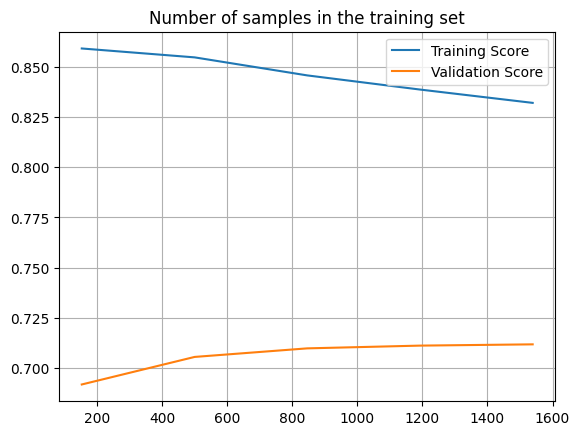

In [8]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.title('Number of samples in the training set')
plt.grid()
plt.legend()
plt.show()